In [103]:
from src.tools import MMSeqs, NCBIDatasets, Prodigal
import pandas as pd
import numpy as np
from src.files import XMLFile, InterProScanFile, FASTAFile, GBFFFile
from utils import * 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from src.classifier import Classifier
from src.sampler import Sampler
from src.dataset import Dataset, build, Pruner
import torch
import seaborn as sns 
import re
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
def dereplicate(path:str, radius:float=0.1):
    dataset = Dataset.from_hdf(path, feature_type='esm_650m_gap')
    pruner = Pruner(radius=radius)
    pruner.fit(dataset)
    dataset = pruner.prune(dataset)
    dataset.write(path.replace('.h5', '_dereplicated.h5'))

def align(path:str):
    df = pd.read_csv(path, index_col=0)
    mmseqs = MMSeqs()
    mmseqs.run(df, module='align', job_name=os.path.basename(path).replace('.csv', ''), sensitivity=10, max_e_value=10)

def load_align(path:str, index:np.ndarray=None) -> pd.DataFrame:
    # Convert the alignment data to a distance matrix. 
    df = MMSeqs.load_align(path)
    align_df = pd.DataFrame(index=index, columns=index) 
    for row in tqdm(df.itertuples(), total=len(df)):
        align_df.loc[row.Index, row.subject_id] = row.sequence_identity
    with pd.option_context('future.no_silent_downcasting', True):
        align_df = align_df.fillna(0.0)
    return align_df

def distances(path:str):
    dataset = Dataset.from_hdf(path, feature_type='esm_650m_gap', attrs=['label', 'genome_id'])
    embeddings = dataset.embedding.to(torch.float16).numpy()
    dists = pairwise_distances(embeddings, metric='minkowski', p=2)
    # dists = torch.cdist(embeddings, embeddings, p=2)
    dists_df = pd.DataFrame(dists, index=dataset.index, columns=dataset.index)
    dists_df.to_csv(path.replace('.h5', '_dists.csv'))

In [ ]:
dereplicate('../data/campylobacterota_dataset_labeled_subset.h5')
dereplicate('../data/campylobacterota_dataset_spurious.h5')

# Clustering the spurious sequences at 90 percent similarity results in 56 clusters. 

Pruner.prune: Removing 207 sequences from the input Dataset.
Pruner.prune: 5090 sequences remaining.
Pruner.prune: Removing 200 sequences from the input Dataset.
Pruner.prune: 97 sequences remaining.


In [135]:
distances('../data/campylobacterota_dataset_labeled_subset_dereplicated.h5')
# distances('../data/campylobacterota_dataset_labeled_subset.h5')
# distances('../data/campylobacterota_dataset_spurious.h5')
# distances('../data/campylobacterota_dataset_spurious_dereplicated.h5')

In [ ]:
dataset_df = pd.read_csv('../data/campylobacterota_dataset_labeled.csv', index_col=0)
dataset_df = pd.concat([dataset_df[dataset_df.label == 0], dataset_df[dataset_df.label == 1].sample(5000, random_state=42)]
dataset_df.to_csv('../data/campylobacterota_dataset_labeled_subset.csv')
dereplicate('../data/campylobacterota_dataset_labeled_subset.csv')

In [ ]:
# genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
# genome_metadata_df = genome_metadata_df[genome_metadata_df.annotation_pipeline.str.contains('PGAP')]
# campylobacterota_genome_ids = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota'].index

# results = Results(genome_ids=campylobacterota_genome_ids, load_labels=True, load_ref=True)
# results.load_predict('../data/results/campylobacterota/campylobacterota_dataset_labeled_subset_predict.csv', model_name='campylobacterota_esm_650m_gap_v301_subset')
# results_df = results.to_df()

In [133]:
(dataset.label == 0).sum()

np.int64(97)

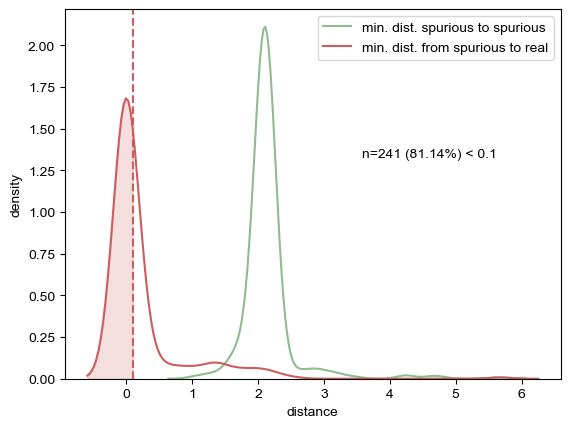

In [ ]:
# dists_df = pd.read_csv('../data/campylobacterota_dataset_labeled_subset_dereplicated_dists.csv', index_col=0)
# dataset = Dataset.from_hdf('../data/campylobacterota_dataset_labeled_subset_dereplicated.h5', feature_type='esm_650m_gap')
dists_df = pd.read_csv('../data/campylobacterota_dataset_labeled_subset_dists.csv', index_col=0)
dataset = Dataset.from_hdf('../data/campylobacterota_dataset_labeled_subset.h5', feature_type='esm_650m_gap')

def figure(dists_df, dataset, radius:float=0.1):
    real_ids = dataset.index[dataset.label == 1]
    spurious_ids = dataset.index[dataset.label == 0]

    min_dists_spurious_to_spurious = dists_df.loc[spurious_ids, spurious_ids].values
    np.fill_diagonal(min_dists_spurious_to_spurious, np.inf)
    min_dists_spurious_to_spurious = min_dists_spurious_to_spurious.min(axis=1)

    min_dists_spurious_to_real = dists_df.loc[spurious_ids, real_ids].values
    np.fill_diagonal(min_dists_spurious_to_real, np.inf)
    min_dists_spurious_to_real = min_dists_spurious_to_real.min(axis=1)

    # It seems like 76 of the sequences might be identical, or at least have zero embedding distance. 

    fig, ax = plt.subplots()
    sns.kdeplot(ax=ax, x=min_dists_spurious_to_real.ravel(), color='darkseagreen', label='min. dist. spurious to spurious')
    sns.kdeplot(ax=ax, x=min_dists_spurious_to_spurious.ravel(), color='indianred', label='min. dist. from spurious to real')
    ax.legend()

    x, y = ax.lines[-1].get_xydata().T
    x, y = x[x < radius], y[x < radius]
    ax.axvline(x=radius, color='indianred', ls='--')
    ax.fill_between(x, y, color='indianred', alpha=0.2)
    n = (min_dists_spurious_to_spurious < radius).sum()
    p = n / len(min_dists_spurious_to_spurious) * 100
    ax.text(0.6, 0.6, f'n={n} ({p:.2f}%) < {radius}', transform=ax.transAxes)

    ax.set_ylabel('density')
    ax.set_xlabel('distance')

    plt.show()

figure: No alignments made between spurious and real sequences.


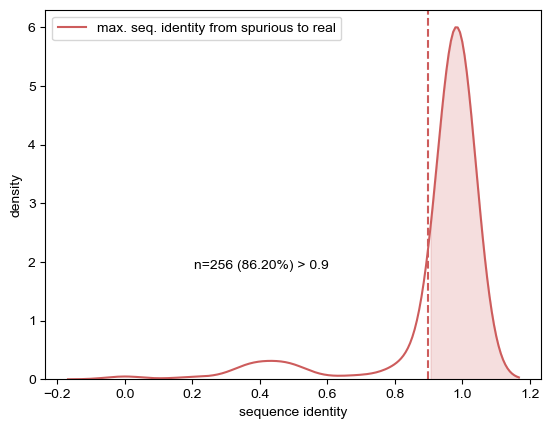

In [152]:
# dataset = Dataset.from_hdf('../data/campylobacterota_dataset_labeled_subset.h5', feature_type='esm_650m_gap')
# align_df = load_align('../data/campylobacterota_dataset_labeled_subset_align.tsv', index=dataset.index)

def figure(align_df, dataset, sequence_identity:float=0.9):
    real_ids = dataset.index[dataset.label == 1]
    spurious_ids = dataset.index[dataset.label == 0]

    max_aligns_spurious_to_spurious = align_df.loc[spurious_ids, spurious_ids].values
    np.fill_diagonal(max_aligns_spurious_to_spurious, 0)
    max_aligns_spurious_to_spurious = max_aligns_spurious_to_spurious.max(axis=1)

    max_aligns_spurious_to_real = align_df.loc[spurious_ids, real_ids].values
    np.fill_diagonal(max_aligns_spurious_to_real, 0)
    max_aligns_spurious_to_real = max_aligns_spurious_to_real.min(axis=1)

    fig, ax = plt.subplots()
    
    if np.all(max_aligns_spurious_to_real == 0):
        print('figure: No alignments made between spurious and real sequences.')
    else:
        sns.kdeplot(ax=ax, x=max_aligns_spurious_to_real.ravel(), color='darkseagreen', label='max. seq. identity spurious to spurious')
    sns.kdeplot(ax=ax, x=max_aligns_spurious_to_spurious.ravel(), color='indianred', label='max. seq. identity from spurious to real')
    ax.legend()

    x, y = ax.lines[-1].get_xydata().T
    x, y = x[x > sequence_identity], y[x > sequence_identity]
    ax.axvline(x=sequence_identity, color='indianred', ls='--')
    ax.fill_between(x, y, color='indianred', alpha=0.2)
    n = (max_aligns_spurious_to_spurious > sequence_identity).sum()
    p = n / len(max_aligns_spurious_to_spurious) * 100
    ax.text(0.3, 0.3, f'n={n} ({p:.2f}%) > {sequence_identity}', transform=ax.transAxes)

    ax.set_ylabel('density')
    ax.set_xlabel('sequence identity')

    plt.show()

figure(align_df, dataset)

In [125]:
# # dists_df = pd.read_csv('../data/campylobacterota_dataset_spurious_dists.csv', index_col=0)
# dataset_df = pd.read_csv('../data/campylobacterota_dataset_labeled_subset.csv', index_col=0)
# dataset = Dataset.from_hdf('../data/campylobacterota_dataset_labeled_subset.h5', feature_type='esm_650m_gap')

# real_ids = dataset_df[dataset_df.label == 1].index
# spurious_ids = dataset_df[dataset_df.label == 0].index

# ax_df = list()
# for radius in np.linspace(0.1, 1.5, 10):
#     pruner = Pruner(radius=radius)
#     pruner.fit(dataset)
#     row = dict()
#     row['n_removed'] = len(pruner.remove_idxs)
#     row['n_removed_real'] = np.isin(pruner.remove_ids, real_ids).sum()
#     row['n_removed_spurious'] = np.isin(pruner.remove_ids, spurious_ids).sum()
#     row['radius'] = radius
#     ax_df.append(row)
# ax_df = pd.DataFrame(ax_df)

# fig, ax = plt.subplots()
# sns.lineplot(ax=ax, data=ax_df, x='radius', y='n_removed', color='darkgray')
# sns.lineplot(ax=ax, data=ax_df, x='radius', y='n_removed_spurious', color='indianred')
# sns.lineplot(ax=ax, data=ax_df, x='radius', y='n_removed_real', color='darkseagreen')
# plt.show()

In [ ]:
dists_df = pd.read_csv('../data/campylobacterota_dataset_labeled_subset_dists.csv', index_col=0)
align_df = load_align('../data/campylobacterota_dataset_labeled_subset_align.tsv', index=dists_df.index)
dataset_df = pd.read_csv('../data/campylobacterota_dataset_labeled_subset.csv', index_col=0)


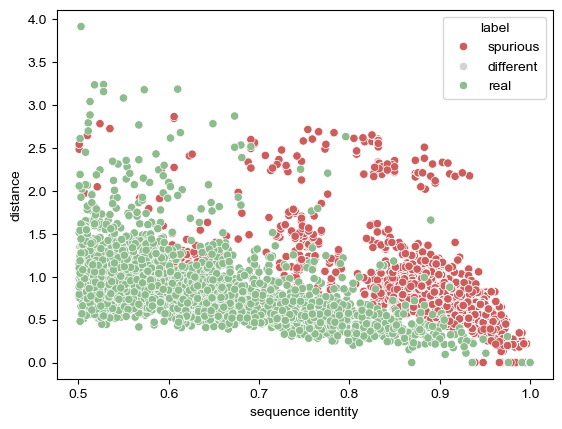

In [ ]:
def figure(dataset_df, align_df, dists_df, min_sequence_identity:float=0.5):
    fig, ax = plt.subplots()

    align_arr = np.tril(align_df) # Avoid plotting the same pair twice. 
    dist_arr = np.tril(dists_df) # Avoid plotting the same pair twice. 
    n = dists_df.shape[0]

    labels = np.array(['spurious' if (label == 0) else 'real' for label in dataset_df.label])
    labels = np.tile(labels, (n, 1))
    labels = np.where(labels == labels.T, labels, 'different') # Mark locations where the labels are different. 
    
    ax_df = dict()
    ax_df['label'] = labels[align_arr > min_sequence_identity]
    ax_df['sequence_identity'] = align_arr[align_arr > min_sequence_identity]
    ax_df['distance'] = dist_arr[align_arr > min_sequence_identity]

    hue_order = ['spurious', 'different', 'real']
    colors = {'real':'darkseagreen', 'spurious':'indianred', 'different':'lightgray'}
    sns.scatterplot(data=ax_df, x='sequence_identity', y='distance', hue='label', hue_order=hue_order, palette=colors, ax=ax)
    sns.move_legend(ax, loc='upper right')

    ax.set_xlabel('sequence identity')
    ax.set_ylabel('distance')

    plt.show()

figure(dataset_df, align_df, dists_df)

# I am clustering at 50 percent similarity, so no two non-spurious sequences have higher than 50 percent identity. 

# What if we take a look at how sequence identity between two real sequences correlates to the distance of the nearest spurious sequence. 

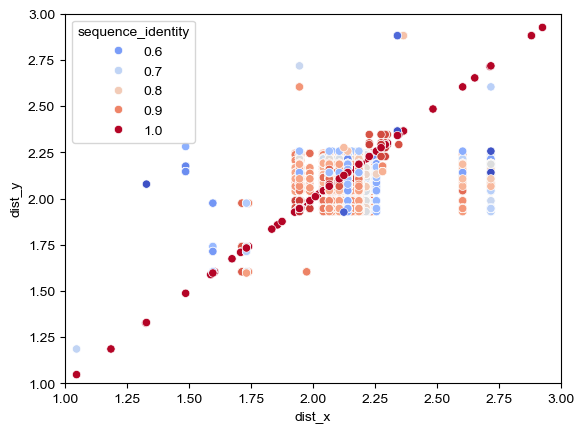

In [ ]:
def figure(dataset_df, align_df, dists_df, min_sequence_identity:float=0.5):
    fig, ax = plt.subplots()

    labels = dataset_df.label.values 
    spurious_ids = dataset_df[labels == 0].index
    
    dists_to_real = dists_df.loc[labels == 0, labels == 1].min(axis=1)
    # dists_to_real = dists_df.loc[labels == 1, labels == 0].mean(axis=1)
    
    align_arr = np.tril(align_df.loc[spurious_ids, spurious_ids].values)
    idxs = np.where(align_arr > min_sequence_identity)

    ax_df = pd.DataFrame()
    ax_df['dist_x'] = dists_to_real.values[idxs[0]]
    ax_df['dist_y'] = dists_to_real.values[idxs[1]]
    ax_df['sequence_identity'] = align_arr[idxs] # .ravel()
    sns.scatterplot(data=ax_df, x='dist_x', y='dist_y', color='darkgray', ax=ax, palette='coolwarm', hue='sequence_identity')

    ax.set_xlim(1, 3)
    ax.set_ylim(1, 3)
    plt.show()


figure(dataset_df, align_df, dists_df)
# Why would there be cases where one sequence's distance to a real sequence is the same as another's?
# Is this related to the fact that I used lower-precision floats?
# Are there any cases where the embeddings are the same but the sequences are different?

8007.0


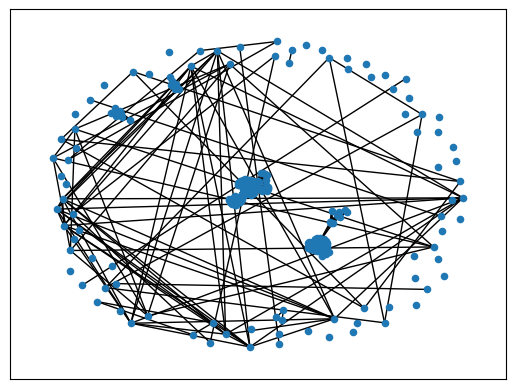

In [195]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

# I think worth trying to visualize the radius neighbors graph of the spurious sequences, because the model doesn't seem to be training properly. 
dataset = Dataset.from_hdf('../data/campylobacterota_dataset_spurious.h5', feature_type='esm_650m_gap')

radius = 0.5
nearest_neighbors = NearestNeighbors(radius=radius, metric='minkowski', p=2)
nearest_neighbors.fit(dataset.embedding.numpy())
graph = nearest_neighbors.radius_neighbors_graph(dataset.embedding.numpy(), mode='connectivity', radius=radius)
graph = graph.toarray()
print(graph.sum())

dists = pairwise_distances(dataset.embedding.numpy())
dists += 1e-30
graph = graph * dists 

np.fill_diagonal(graph, 0)
graph = nx.Graph(graph)

fig, ax = plt.subplots()

nx.draw_networkx(graph, ax=ax, with_labels=False, node_size=20)
plt.show()


In [184]:
max(dists.ravel())

np.float64(6.589632539894737)

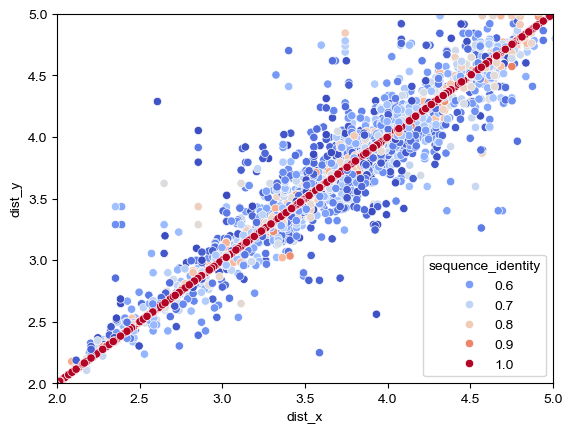

In [166]:
def figure(dataset_df, align_df, dists_df, min_sequence_identity:float=0.5):
    fig, ax = plt.subplots()

    labels = dataset_df.label.values 
    real_ids = dataset_df[labels == 1].index
    
    dists_to_spurious = dists_df.loc[labels == 1, labels == 0].min(axis=1)
    # dists_to_spurious = dists_df.loc[labels == 1, labels == 0].mean(axis=1)
    
    align_arr = np.tril(align_df.loc[real_ids, real_ids].values)
    idxs = np.where(align_arr > min_sequence_identity)

    ax_df = pd.DataFrame()
    ax_df['dist_x'] = dists_to_spurious.values[idxs[0]]
    ax_df['dist_y'] = dists_to_spurious.values[idxs[1]]
    ax_df['sequence_identity'] = align_arr[idxs] # .ravel()
    sns.scatterplot(data=ax_df, x='dist_x', y='dist_y', color='darkgray', ax=ax, palette='coolwarm', hue='sequence_identity')
    ax.set_xlim(2, 5)
    ax.set_ylim(2, 5)
    plt.show()


figure(dataset_df, align_df, dists_df)

In [ ]:
# I am curious about how much the messed up sequence boundaries effect the embedding. 
is_n_truncated = lambda df : ((df.query_start > df.top_hit_start) & (df.query_strand == 1)) | ((df.query_stop < df.top_hit_stop) & (df.query_strand == -1)) 
is_c_truncated = lambda df : ((df.query_stop < df.top_hit_stop) & (df.query_strand == 1)) | ((df.query_start > df.top_hit_start) & (df.query_strand == -1)) 
is_n_extended = lambda df : ((df.query_start < df.top_hit_start) & (df.query_strand == 1)) | ((df.query_stop > df.top_hit_stop) & (df.query_strand == -1)) 
is_c_extended = lambda df : ((df.query_stop > df.top_hit_stop) & (df.query_strand == 1)) | ((df.query_start < df.top_hit_start) & (df.query_strand == -1)) 

df = dataset_df[dataset_df.category == 'match'].copy()
df = df[is_n_extended(df)].copy()
df['n_met'] = df.seq.apply(lambda s : s.count('M'))
df = df[(df.n_met < 15) & (df.n_met > 3)].copy()

trunc_df = []
for row in df.itertuples():
    seq, i = row.seq, 0
    length = len(seq)
    while seq.count('M') >= 2:
        new_row = dict()
        new_row['original_id'] = row.Index 
        new_row['id'] = row.Index + f'({i})'
        new_row['seq'] = seq
        new_row['trunc_length'] = length - len(seq)
        trunc_df.append(new_row)

        seq = seq[1:] # Remove the first methionine. 
        seq = seq[seq.index('M'):]

        i += 1
        
trunc_df = pd.DataFrame(trunc_df)
trunc_df = trunc_df.set_index('id')

In [ ]:
from src.embed import ESMEmbedder

embedder = ESMEmbedder()
embeddings = embedder(list(trunc_df.seq))

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PLMEmbedder.__call__: 100%|██████████| 143/143 [06:18<00:00,  2.65s/it]


In [ ]:
embeddings_df = pd.DataFrame(embeddings, index=trunc_df.index)
embeddings_df.to_csv('embeddings.csv')

In [ ]:
# ncbi_genome_metadata_df = load_ncbi_genome_metadata()

# fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(2 * 6.2, 4.8), width_ratios=[0.4, 0.6])

# counts, bins, _ = ax_a.hist(ncbi_genome_metadata_df.gc_percent, bins=25, width=2, edgecolor='black', color='lightgray')
# ax_a.set_ylabel('density')
# ax_a.set_xlabel('GC percent')

# level = 'phylum'
# y = ncbi_genome_metadata_df.groupby(level).gc_percent.mean().values # .sort_values(ascending=True)
# x = ncbi_genome_metadata_df.groupby(level).apply(len, include_groups=False).values # .sort_values(ascending=True)
# y_err = ncbi_genome_metadata_df.groupby(level).apply(lambda df : df.gc_percent.std() / np.sqrt(len(df)), include_groups=False) # .loc[y.index]
# ax_b.errorbar(x, y, yerr=y_err, ls='', lw=0.7, capsize=2, color='black')
# ax_b.scatter(x, y, color='black', s=5)

# phyla = ncbi_genome_metadata_df.groupby(level).first().index
# ax_b.scatter(x[phyla == 'Campylobacterota'], y[phyla == 'Campylobacterota'], facecolor='none',linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
# ax_b.scatter(x[phyla == 'Planctomycetota'], y[phyla == 'Planctomycetota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)
# ax_b.scatter(x[phyla == 'Deinococcota'], y[phyla == 'Deinococcota'], facecolor='none', linewidths=1.5, edgecolors='seagreen', s=100, zorder=1000)

# ax_b.set_xscale('log')
# ax_b.set_xlabel(f'log({level} size)')
# ax_b.set_ylabel('GC percent')

# plt.show()

In [ ]:
# # Start by selecting a few phyla in a reasonable size range with varying GC contents.
# def sample(genome_metadata_df:pd.DataFrame, min_phylum_size:int=90, max_phylum_size:int=200):

#     phylum_sizes = genome_metadata_df.groupby('phylum').apply(len, include_groups=False)
#     phylum_sizes = phylum_sizes[(phylum_sizes > min_phylum_size) & (phylum_sizes < max_phylum_size)]

#     genome_metadata_df = genome_metadata_df[genome_metadata_df.phylum.isin(phylum_sizes.index)]
    
#     phylum_gc_percent = genome_metadata_df.groupby('phylum').gc_percent.mean() 
#     phylum_gc_percent = phylum_gc_percent.sort_values(ascending=True)
    
#     phyla = dict()
#     phyla['low_gc_content'] = phylum_gc_percent.index[0]
#     phyla['med_gc_content'] = phylum_gc_percent.index[len(phylum_gc_percent) // 2]
#     phyla['high_gc_content'] = phylum_gc_percent.index[-1]

#     print('Low-GC content phylum:', phyla['low_gc_content'])
#     print('Medium-GC content phylum:', phyla['med_gc_content'])
#     print('High-GC content phylum:', phyla['high_gc_content'])

#     genome_ids = {category:genome_metadata_df.index[genome_metadata_df.phylum == phylum] for category, phylum in phyla.items()}
#     return genome_ids

# genome_ids = sample(ncbi_genome_metadata_df)

# ncbi = NCBIDatasets(genome_dir='../data/genomes', gbff_dir='../data/proteins/ncbi')
# ncbi.run(genome_ids=genome_ids['low_gc_content'], metadata_only=False)

In [ ]:
# genome_metadata_df = list()
# for category, genome_ids_ in genome_ids.items():
#     df = ncbi_genome_metadata_df.loc[genome_ids_, :].copy()
#     df['gc_percent_category'] = category
#     genome_metadata_df.append(df)
# genome_metadata_df = pd.concat(genome_metadata_df)
# genome_metadata_df.to_csv('../data/genome_metadata.csv')

In [ ]:
# genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
# genome_metadata_df = genome_metadata_df[genome_metadata_df.annotation_pipeline.str.contains('PGAP')]
# campylobacterota_genome_ids = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota'].index

# build(campylobacterota_genome_ids, labeled=True, output_path='../data/campylobacterota_dataset_labeled.csv', max_length=2000)
# build(campylobacterota_genome_ids, labeled=False, output_path='../data/campylobacterota_dataset.csv', max_length=2000)

array([1, 0])

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import balanced_accuracy_score
# from sklearn.preprocessing import StandardScaler

# class BenchmarkClassifier():

#     def __init__(self, feature_col:str='query_length'):

#         self.model = LogisticRegression(class_weight='balanced', C=1) # , multi_class='multinomial') 
#         self.scaler = StandardScaler()
#         self.feature_col = feature_col

#     def predict(self, df:pd.DataFrame, include_outputs:bool=True):
#         X = df[[self.feature_col]].values
#         X = self.scaler.transform(X)
#         model_labels = self.model.predict(X)
#         model_outputs = self.model.predict_proba(X)

#         return model_labels if (not include_outputs) else (model_labels, model_outputs)

#     def fit(self, df:pd.DataFrame):
#         X, labels = df[[self.feature_col]].values, df['label'].values
#         X = self.scaler.fit_transform(X)
#         self.model.fit(X, labels)

# model = BenchmarkClassifier()
# model.fit(train_df)

# df = test_df[['label', 'query_length']].copy()
# df['model_label'], outputs = model.predict(test_df, include_outputs=True)
# df['model_output_0'], df['model_output_1'] = outputs[:, 0].ravel(), outputs[:, 1].ravel()

# print('Balanced accuracy:', balanced_accuracy_score(df.label.values, df.model_label.values))
# print('Precision (class 0):', precision(df, class_=0))
# print('Recall (class 0):', recall(df, class_=0))
# print('Number of false negatives:', ((df.label == 1) & (df.model_label == 0)).sum())


# confusion_matrix = np.where((df.model_label == 1) & (df.label == 0), 'false positive', '')
# confusion_matrix = np.where((df.model_label  == 1) & (df.label == 1), 'true positive', confusion_matrix)
# confusion_matrix = np.where((df.model_label == 0) & (df.label == 1), 'false negative', confusion_matrix)
# confusion_matrix = np.where((df.model_label  == 0) & (df.label == 0), 'true negative', confusion_matrix)
# df['confusion_matrix'] = confusion_matrix

# benchmark_fn = df[df.confusion_matrix == 'false negative'].index
# fn = pred_df[pred_df.confusion_matrix == 'false negative'].index
# np.intersect1d(fn, benchmark_fn)

In [ ]:
# There still seems to be something wrong with the training data, perhaps I am still misclassifying the spurious sequences?
# It is possible my "in-frame" check is wrong, it's possible I should only see if either edge is a multiple of 3 base pairs away, 
# as opposed to both.

# It seems as though 684 of the sequences flagged as spurious have an overlap length of 0, so maybe I should be counting those as intergenic?
# Ok, so I think because of how frequent gene overlap is, I should be allowing some (considering genes with less than a certain amount of overlap to be intergenic)
# I should also be very conservative, i.e. allow a comparatively large amount of overlap. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/ 
